In [1]:
import os
import re
import sys
print(f'Python: {sys.prefix}')
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib

sys.path.append(('./utils'))
print(os.getcwd())
print(sys.path)
import mgen
import datasetmaker
import shared as sd
import loaders as ld
import vis

import multiprocessing
import multiprocessing.pool
import fnmatch
import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from skimage import restoration
from scipy import signal, ndimage
from natsort import natsorted
import seaborn as sns

from IPython.display import clear_output
# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
# sys.path.append(os.path.abspath('../'))
import pyapi_denise as api

Python: /Users/pavelplotnitskii/opt/anaconda3/envs/torch_cpu
/Users/pavelplotnitskii/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
['/Users/pavelplotnitskii/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha', '/Users/pavelplotnitskii/.vscode/extensions/ms-toolsai.jupyter-2022.3.1000901801/pythonFiles', '/Users/pavelplotnitskii/.vscode/extensions/ms-toolsai.jupyter-2022.3.1000901801/pythonFiles/lib/python', '/Users/pavelplotnitskii/opt/anaconda3/envs/torch_cpu/lib/python39.zip', '/Users/pavelplotnitskii/opt/anaconda3/envs/torch_cpu/lib/python3.9', '/Users/pavelplotnitskii/opt/anaconda3/envs/torch_cpu/lib/python3.9/lib-dynload', '', '/Users/pavelplotnitskii/opt/anaconda3/envs/torch_cpu/lib/python3.9/site-packages', '/Users/pavelplotnitskii/.local/lib/python3.9/site-packages', './utils']
Madagascar not found (called from utils.loaders)! It is OK unless you want to generate data from scratch. Install m8r from ahay.org
Madagascar not found (ca

/var/folders/cd/46fjmff95pl74m9hlt89jyj80000gn/T/ipykernel_6106/867968574.py:27: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


ModuleNotFoundError: No module named 'seaborn'

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 150,
    # 'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
#     cmap = 'gist_ncar'
def plot_hist(dist,title0=''):
    sns.set(style='whitegrid', 
#         palette="deep", 
    palette="Blues_r", 
    rc={"figure.figsize": [7, 5]})
    plt.figure()
    title=title0+';mean,std='+str(np.mean(dist))+','+str(np.std(dist)) 
    sns.histplot(dist, kde=False, stat='count', 
                    color = 'navy',
                    alpha = 0.85,bins=100,
                     line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
                     binrange=(np.min(dist), np.max(dist)),
                    #  binrange=(-250, 250),
                    ).set(xlabel='Velocity perturbation, km / s', ylabel='Count',title=title,
                #             ylim=[0,max_count],
                    xlim=[np.min(dist), np.max(dist)])
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 
def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x
def plot_log_model(mm, dx, nx, nz0, _src):
    v = mm.copy() / 1000
    plt.figure(); ax = plt.gca();
    map_src = _src.x / dx < nx
    plt.scatter(_src.x[map_src]/1000, _src.y[map_src]/1000, 1, color='w'); 
    cmap='RdBu_r'
    im = ax.imshow(v[:,:nx0], cmap=cmap, extent=[0, nx0 * dx / 1000, 0, nz0 * dx/1000], 
                   origin='upper', vmin=1.45, vmax=3.5); 
    divider = make_axes_locatable(ax); 
    cax = divider.append_axes("right", size="5%", pad=0.05); cbar = plt.colorbar(im, cax=cax); cbar.set_label('km/s');
    ax.set_xlabel('km'); ax.set_ylabel('km'); ax.set_title(f); ax.invert_yaxis();

    log = model_log.vp[:, log_idx]
    vh = 420*dx * np.ones_like(log)/ 1000 
    ax.plot(vh, np.arange(len(log))*dx/1000, 'k--')
    ax.plot(vh + (log[::-1] - min(log)) / 1000, np.arange(len(log))*dx/1000, 'k')
    plt.pause(0.001)

In [4]:

root_fwi = './out_ac/'
root_out = '/data/oleg/data/'
root_field = os.path.join('./data_cgg/')
# Data loading
# data_paths='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496'
# data_paths='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496_test4'
data_paths=[
            '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496',
            '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_fwi_strategy_13_dsrc_200_pseudo_field_nx_496_test4']
data_paths=['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling']
# data_paths=['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_3_21_08']
dx=25;dz=25
########################## find directories in the folder
files=[]
for data_path in data_paths:
    tmp=fnmatch.filter(os.listdir(data_path),'*.npz')
    for file_ in tmp:
        path_=os.path.join(data_path,file_)
        files.append(path_)
##########################
# files=fnmatch.filter(os.listdir(data_path),'*.npz')
test = fnmatch.filter(files, '*__*')
train=list(set(files)-set(test))
# test=list(set(test)-set(fnmatch.filter(files, '*_bad_initial*')))
# train=train[0:100]
print(len(files))
print(test)
print(len(train+test))

4084
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam_linear_initial.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Overthrust.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi_linear_initial.npz', '/home/plotnips

In [5]:
from functools import partial
def unpack_file(NAME):
    pts=NAME.split('/')
    f_name=pts[-1]
    f_name=f_name[:-4]; 
    # print('reading ',f_name)
    with open(NAME, 'rb') as f:
        data=np.load(f)
        model=data['models'].squeeze()
        initial_model=data['models_init'].squeeze()
        input_data=data['input_data'].squeeze()
        output_data=data['output_data'].squeeze()
        input_data_real_amplitudes=data['input_data_real_amplitudes'].squeeze()
        output_data_real_amplitudes=data['output_data_real_amplitudes'].squeeze()
        data.close()
    fwi_result=input_data_real_amplitudes+initial_model
    data_structure={'model':model.T,'initial_model':initial_model.T,'input_data':input_data.T,'input_data_real_amplitudes':input_data_real_amplitudes.T
        ,'output_data_real_amplitudes':output_data_real_amplitudes.T,'name':f_name,'output_data':output_data.T,'fwi_result':fwi_result.T}
    # Plot_image(M0.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M0',Aspect='equal')
    # Plot_image(M2.T,Show_flag=0,Save_flag=1,Save_pictures_path=Save_pictures_path,Title=f_name+'_M2',Aspect='equal')
    return data_structure
def extract_structure_field(list_of_structures,field):
    list_of_arrays=[]
    for i in range(len(list_of_structures)):
        list_of_arrays.append( list_of_structures[i][field] )
    return list_of_arrays
flag_single_thread_processing=0
LIST=test
test_models_data=[]
dataset_models_data=[]
if flag_single_thread_processing == 1:
    for NAME in test:
        data_structure=unpack_file(NAME)
        test_models_data.append(data_structure)
        # test_models_data.append([model,initial_model])
    # print(test_models_data[0]['input_data'])
elif flag_single_thread_processing==0:
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-5)
    temp = partial(unpack_file)
    test_models_data = pool.map(func=temp, iterable=test)
    pool.close()
    pool.join()
    pool = multiprocessing.Pool(multiprocessing.cpu_count()-5)
    temp = partial(unpack_file)
    dataset_models_data = pool.map(func=temp, iterable=train)
    pool.close()
    pool.join()

In [6]:
print(test)
fwi_result_test=extract_structure_field(test_models_data,'fwi_result')
test_models_inp_data=extract_structure_field(test_models_data,'input_data_real_amplitudes')
for f in fwi_result_test:
    Min=np.min(f)
    Max=np.max(f)
    # print(Min,Max)
for f,name in zip(test_models_inp_data,test):
    print(name.split('/')[-1],np.min(f),np.max(f))

['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam_linear_initial.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Overthrust.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi_linear_initial.npz', '/home/plotnips/Drop

In [7]:
fwi_result=np.asarray(extract_structure_field(dataset_models_data,'fwi_result'),dtype=np.float32)
x_ra=np.asarray(extract_structure_field(dataset_models_data,'input_data_real_amplitudes'),dtype=np.float32)
t_ra=np.asarray(extract_structure_field(dataset_models_data,'output_data_real_amplitudes'),dtype=np.float32)
initial_model=np.asarray(extract_structure_field(dataset_models_data,'initial_model'),dtype=np.float32)
model=np.asarray(extract_structure_field(dataset_models_data,'model'),dtype=np.float32)
train_dict={'fwi_result':fwi_result,'x_ra':x_ra,'t_ra':t_ra,'initial_model':initial_model,'model':model}

# Create pandas dataframe for testing samples  

In [8]:
test_dict={'fwi_result':extract_structure_field(test_models_data,'fwi_result'),
            'x_ra':extract_structure_field(test_models_data,'input_data_real_amplitudes'),
            't_ra':extract_structure_field(test_models_data,'output_data_real_amplitudes'),
            'initial_model':extract_structure_field(test_models_data,'initial_model'),
            'model':extract_structure_field(test_models_data,'model')    }

In [9]:
stats=np.empty((train_dict['fwi_result'].shape[0],12))
stats[:,0]=np.max(np.absolute(train_dict['x_ra']),axis=(1,2))
stats[:,1]=np.max(np.absolute(train_dict['t_ra']),axis=(1,2))
stats[:,2]=np.max((train_dict['x_ra']),axis=(1,2))
stats[:,3]=np.min((train_dict['x_ra']),axis=(1,2))
stats[:,4]=np.max((train_dict['t_ra']),axis=(1,2))
stats[:,5]=np.min((train_dict['t_ra']),axis=(1,2))
stats[:,6]=np.max((train_dict['fwi_result']),axis=(1,2))
stats[:,7]=np.min((train_dict['fwi_result']),axis=(1,2))
stats[:,8]=np.max((train_dict['model']),axis=(1,2))
stats[:,9]=np.min((train_dict['model']),axis=(1,2))
stats[:,10]=np.max((train_dict['initial_model']),axis=(1,2))
stats[:,11]=np.min((train_dict['initial_model']),axis=(1,2))
df = pd.DataFrame(stats,columns=['x_ra','t_ra',
'x_ra_max','x_ra_min',
't_ra_max','t_ra_min',
'fwi_result_max','fwi_result_min',
'model_max','model_min',
'initial_model_max','initial_model_min'])
df.insert(0,'filename',train)

# Remove outliers, and updates below 50. 

4074
3690
3592


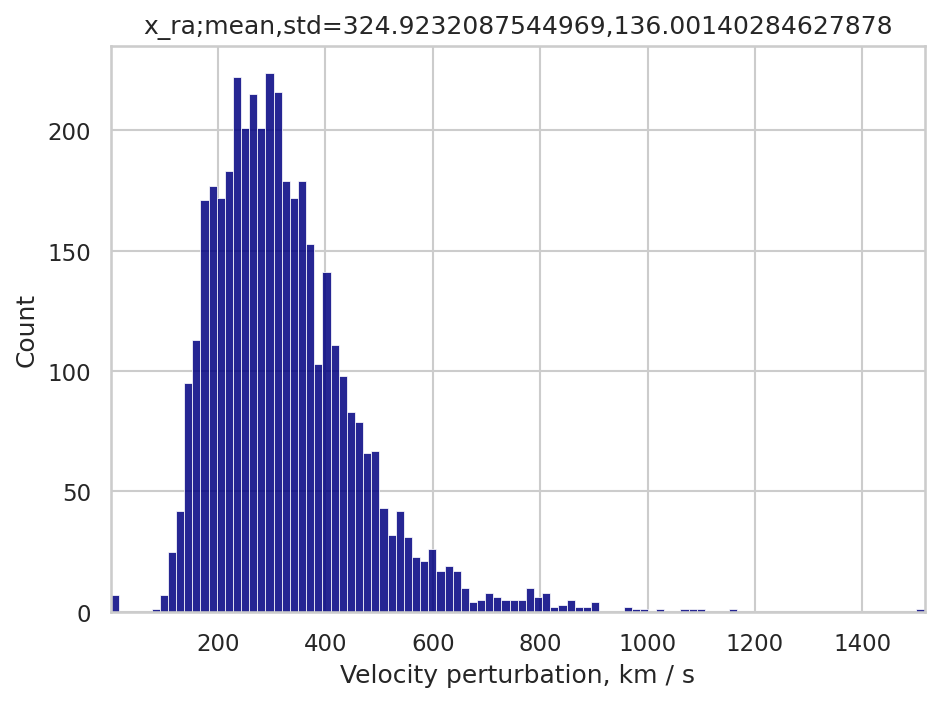

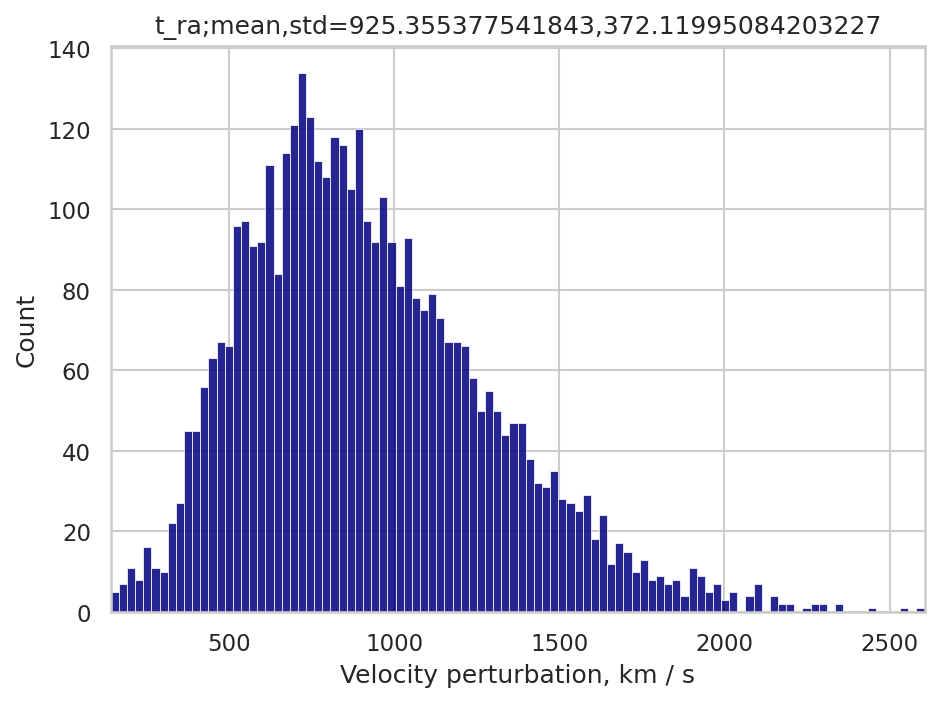

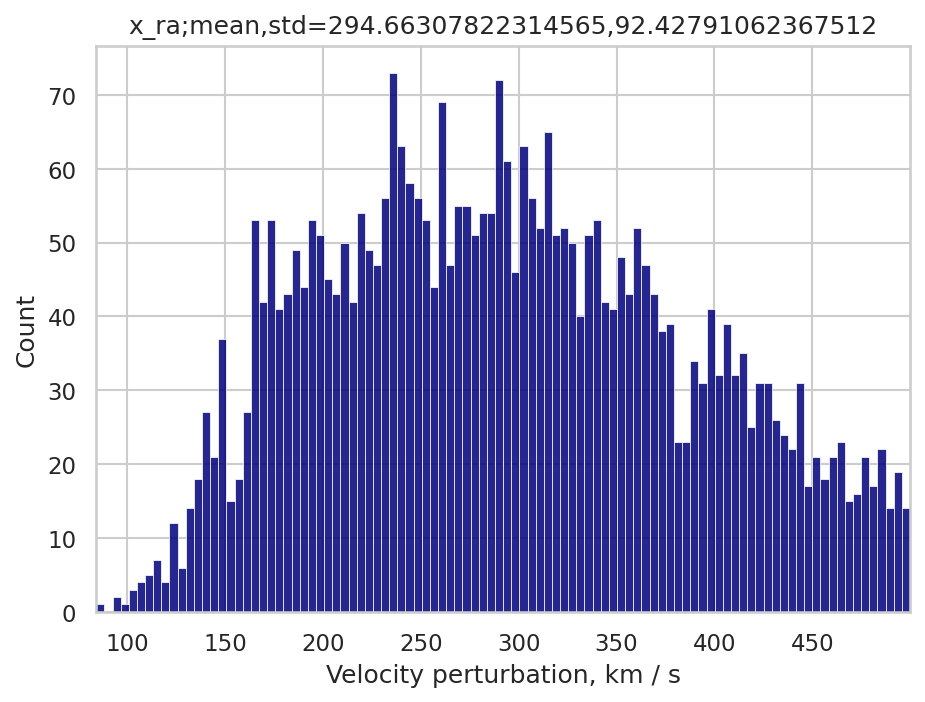

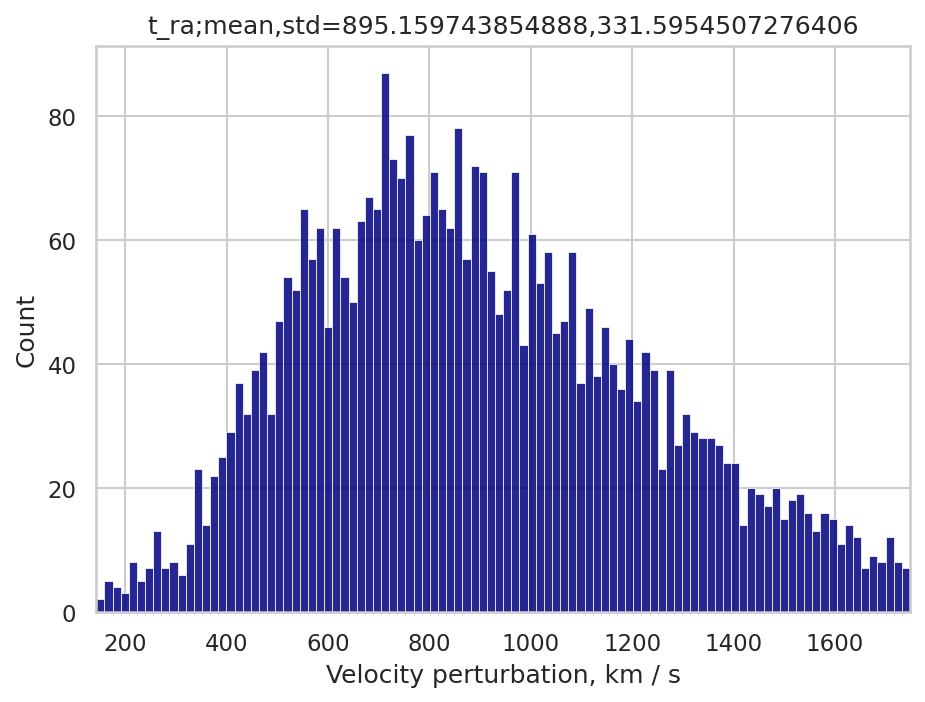

In [10]:
plot_hist(df['x_ra'],title0='x_ra')
plot_hist(df['t_ra'],title0='t_ra')
df=df.sort_values(by=['x_ra'],ascending=False)
print(len(df))
df=df[(df['x_ra']>50) & (df['x_ra']<500)]
print(len(df))
df=df[(df['t_ra']>0) & (df['t_ra']<1750)]
plot_hist(df['x_ra'],title0='x_ra')
plot_hist(df['t_ra'],title0='t_ra')
print(len(df))

# Create pandas dataframe for testing samples  

In [11]:
print(len(test))
print(test)
stats_test=np.empty((len(test_dict['fwi_result']),12))
for i in range(len(test)):
    stats_test[i,0]=np.max(np.absolute(test_dict['x_ra'][i]))
    stats_test[i,1]=np.max(np.absolute(test_dict['t_ra'][i]))
    ##
    stats_test[i,2]=np.max((test_dict['x_ra'][i]))
    stats_test[i,3]=np.min((test_dict['x_ra'][i]))
    stats_test[i,4]=np.max((test_dict['t_ra'][i]))
    stats_test[i,5]=np.min((test_dict['t_ra'][i]))
    stats_test[i,6]=np.max((test_dict['fwi_result'][i]))
    stats_test[i,7]=np.min((test_dict['fwi_result'][i]))
    stats_test[i,8]=np.max((test_dict['model'][i]))
    stats_test[i,9]=np.min((test_dict['model'][i]))
    stats_test[i,10]=np.max((test_dict['initial_model'][i]))
    stats_test[i,11]=np.min((test_dict['initial_model'][i]))
df_test = pd.DataFrame(stats_test,columns=['x_ra','t_ra',
'x_ra_max','x_ra_min',
't_ra_max','t_ra_min',
'fwi_result_max','fwi_result_min',
'model_max','model_min',
'initial_model_max','initial_model_min'])
df_test.insert(0,'filename',test)
# print(df_test)

10
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam_linear_initial.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Overthrust.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi_linear_initial.npz', '/home/plotnips/D

# Unite train and test pandas dataframes to calculate scaling constants for new dataset

In [12]:
df_all=pd.concat([df_test,df])
# print(df_all['filename'][0:1])
# aa=df_all['filename'][0:1].to_list()
# print(aa)
# print(df_test.shape)
# print(df.shape)
print(df_all['x_ra_max'].max())
print(df_all['x_ra_min'].min())
print(df_all['model_max'].max())
print(df_all['model_min'].min())
print(df_all['initial_model_max'].max())
print(df_all['initial_model_min'].min())
print(test)

499.88232421875
-716.020263671875
4700.0
1039.5791015625
4159.6962890625
1490.0
['/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Marmousi.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam_linear_initial.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Overthrust.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_above_water_better_scaling/model__Seam.npz', '/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_pseudofield_data_cnn_13_test_gradhor_start_abov

# Calculate min-max scaling constants for new dataset

In [13]:
print(x_ra.shape)
print(x_ra.min())
scaling_constants_dict={'x':[df_all['x_ra_max'].max(),df_all['x_ra_min'].min()],
    't':[df_all['t_ra_max'].max(),df_all['t_ra_min'].min()],
    'init_model':[df_all['initial_model_max'].max(),df_all['initial_model_min'].min()],
    'model':[df_all['model_max'].max(),df_all['model_min'].min()],
    'fwi_res':[df_all['fwi_result_max'].max(),df_all['fwi_result_min'].min()]
    }
print(scaling_constants_dict)

(4074, 150, 496)
-1515.8442
{'x': [499.88232421875, -716.020263671875], 't': [1748.0816650390625, -1633.7294921875], 'init_model': [4159.6962890625, 1490.0], 'model': [4700.0, 1039.5791015625], 'fwi_res': [4407.12451171875, 1460.7884521484375]}


# Create new dataset

In [14]:
import pickle
new_dataset_path='/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_2'
os.makedirs(new_dataset_path,exist_ok=True)
api._cmd(f"ls {new_dataset_path} | wc -l")
############
new_dataset_file_list=test+df['filename'].to_list()
for count,item in enumerate(new_dataset_file_list):
    tmp=item.split('/')[-1]
    tmp=tmp.split('.npz')[0]
    new_dataset_file_list[count]=tmp
############    create data to create new dataset
data_dict={'new_dataset_file_list':new_dataset_file_list,'scaling_constants_dict':scaling_constants_dict}
with open(os.path.join('../','fwi','dataset_to_create_new.pkl'), 'wb') as output:
    pickle.dump(data_dict,output,4)
with open(os.path.join('../','fwi','dataset_to_create.pkl'),'rb') as input:
    data_dict_old=pickle.load(input)
print(os.getcwd())
print('old')
print(data_dict_old['scaling_constants_dict'])
print('new')
print(data_dict['scaling_constants_dict'])
scaling_constants_dict_test={'x':[df_test['x_ra_max'].max(),df_test['x_ra_min'].min()],
    't':[df_test['t_ra_max'].max(),df_test['t_ra_min'].min()],
    'init_model':[df_test['initial_model_max'].max(),df_test['initial_model_min'].min()],
    'model':[df_test['model_max'].max(),df_test['model_min'].min()],
    'fwi_res':[df_test['fwi_result_max'].max(),df_test['fwi_result_min'].min()]}
print('test')
print(scaling_constants_dict_test)
for f,name in zip(test_models_inp_data,test):
    print(name.split('/')[-1],np.min(f),np.max(f))

ls /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/datasets/gen3_marine_2 | wc -l
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha
old
{'x': [904.1025390625, -906.132568359375], 't': [1748.0816650390625, -1673.467041015625], 'init_model': [4159.6962890625, 1490.0], 'model': [4700.0, 1039.5791015625], 'fwi_res': [4495.79931640625, 1460.7884521484375]}
new
{'x': [499.88232421875, -716.020263671875], 't': [1748.0816650390625, -1633.7294921875], 'init_model': [4159.6962890625, 1490.0], 'model': [4700.0, 1039.5791015625], 'fwi_res': [4407.12451171875, 1460.7884521484375]}
test
{'x': [492.134765625, -716.020263671875], 't': [1359.27490234375, -798.028076171875], 'init_model': [3987.460693359375, 1490.0], 'model': [4700.0, 1039.5791015625], 'fwi_res': [4240.23779296875, 1460.7884521484375]}
model__Marmousi.npz -716.02026 467.3379
model__Seam_linear_initial.npz -242.28711 327.39478
model__Overthrust.npz -506.1267 492.13477
mode

In [16]:
# data_dict2['scaling_constants_dict']
# data_dict2['new_dataset_file_list']

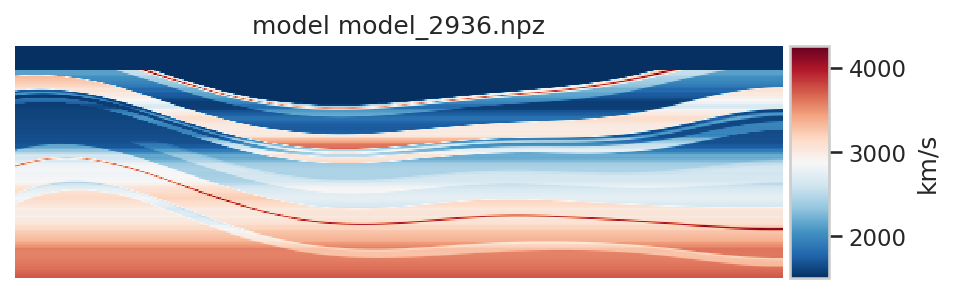

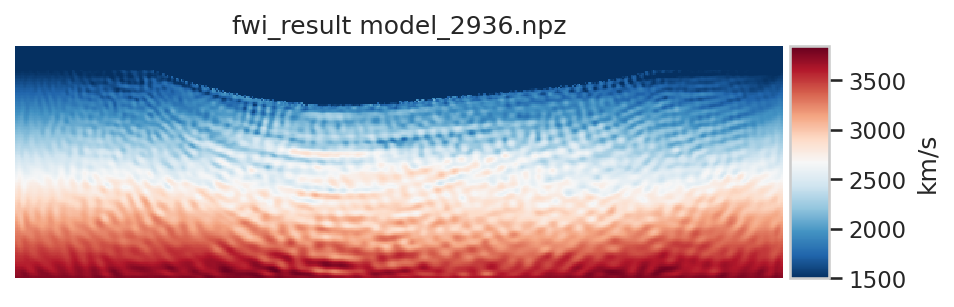

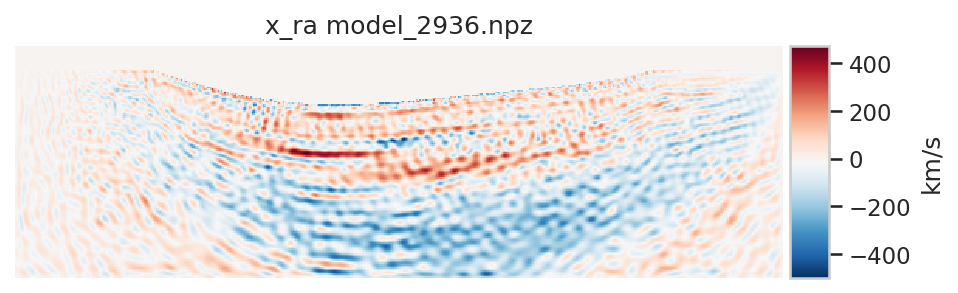

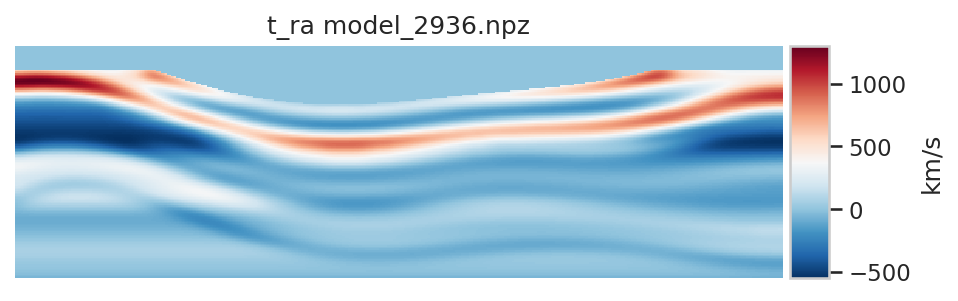

In [17]:
set1=df[0:1]
for i in set1.filename:
    data_structure=unpack_file(i)
    vis.plot_model(np.flipud(data_structure['model']),title='model '+i.split('/')[-1],axis='off')
#     vis.plot_model(np.flipud(data_structure['initial_model']),title='initial_model '+i.split('/')[-1],axis='off')
    vis.plot_model(np.flipud(data_structure['fwi_result']),title='fwi_result '+i.split('/')[-1],axis='off')
    vis.plot_model(np.flipud(data_structure['input_data_real_amplitudes']),title='x_ra '+i.split('/')[-1],axis='off')
#     vis.plot_model(np.flipud(data_structure['input_data']),title='x '+i.split('/')[-1],axis='off')
    vis.plot_model(np.flipud(data_structure['output_data_real_amplitudes']),title='t_ra '+i.split('/')[-1],axis='off')

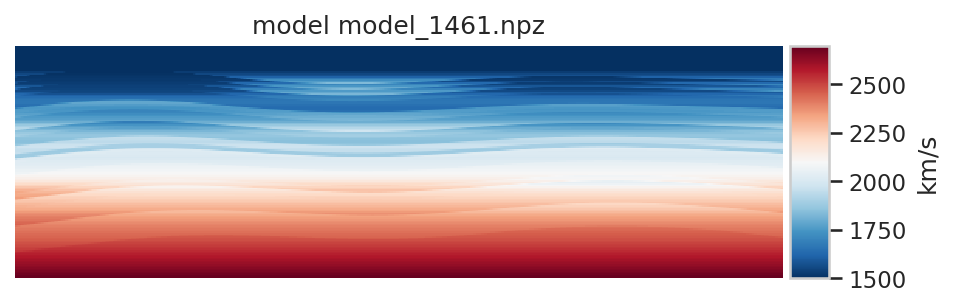

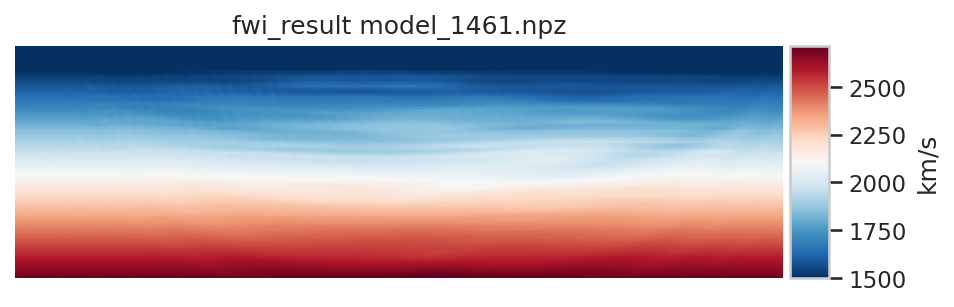

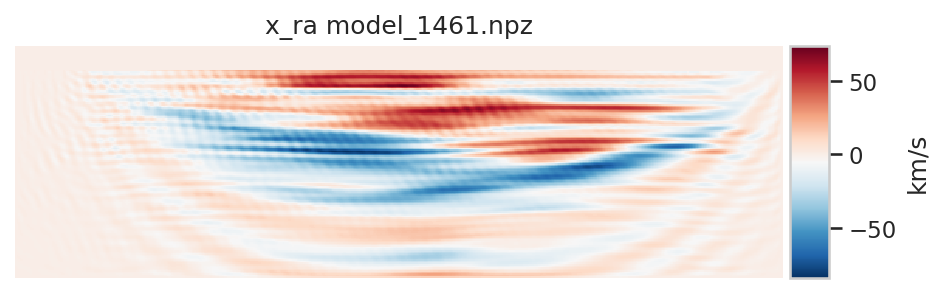

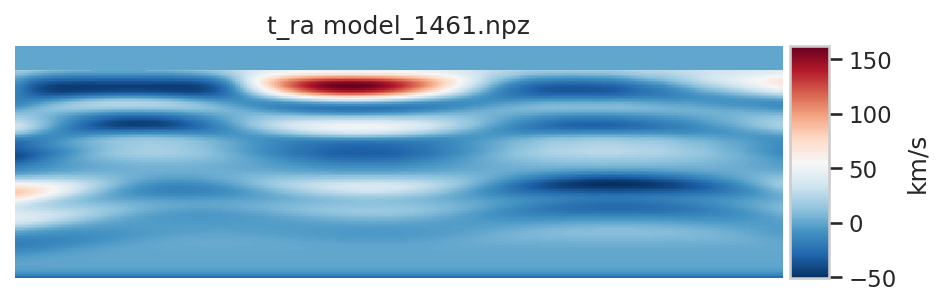

In [18]:
set1=df[-1:]
for i in set1.filename:
    data_structure=unpack_file(i)
    vis.plot_model(np.flipud(data_structure['model']),title='model '+i.split('/')[-1],axis='off')
#     vis.plot_model(np.flipud(data_structure['initial_model']),title='initial_model '+i.split('/')[-1],axis='off')
    vis.plot_model(np.flipud(data_structure['fwi_result']),title='fwi_result '+i.split('/')[-1],axis='off')
    vis.plot_model(np.flipud(data_structure['input_data_real_amplitudes']),title='x_ra '+i.split('/')[-1],axis='off')
#     vis.plot_model(np.flipud(data_structure['input_data']),title='x '+i.split('/')[-1],axis='off')
    vis.plot_model(np.flipud(data_structure['output_data_real_amplitudes']),title='t_ra '+i.split('/')[-1],axis='off')

In [19]:
# Images
par_box = {'vmin': 1500, 'vmax': 4500}
par_box_km = {'vmin': 1.5, 'vmax': 4.5}
vis.plot_model(np.mean(other_models, 0) / 1000, title='Mean', axis='off', cax_label='km/s', 
#                colorbar=False,
               **par_box_km)
vis.plot_model(np.std(other_models, 0), title='STD', 
#                colorbar=False,
               axis='off')
# print(np.linspace(0, nmodels-1, 4))
# for i in [int(np.floor(x)) for x in np.linspace(0, nmodels-1, 4)]:
#     vis.plot_model(other_models[i], axis='off', colorbar=False, **par_box
# #                    title=f'Model {i+1} / {nmodels}'
#                   )

NameError: name 'other_models' is not defined

In [ ]:
print(nmodels)
vol = np.concatenate([np.expand_dims(m, 0) for m in other_models], 0)
print(vol.shape)

In [ ]:
# dist = np.mean((vol - np.mean(vol, keepdims=True))[:, :, log_idx], 1)
the_log = (vol - np.mean(vol, keepdims=True))[:, :, idx_dist] / 1000
print(the_log.shape)
dist = the_log[:, the_log.shape[-1] // 2]
print(dist.shape)

sns.set(style='whitegrid', 
#         palette="deep", 
        palette="Blues_r", 
        rc={"figure.figsize": [7, 5]})


sns.histplot(dist, kde=False, stat='count', 
            color = 'navy',
            alpha = 0.85,
             line_kws={ 'color': 'k', 'linestyle': 'dashed', 'linewidth': 2},
             binrange=(0.99 * np.min(dist), 0.9 * np.max(dist)),
            ).set(xlabel='Velocity perturbation, km / s', ylabel='Count');